In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1. Load Data
print("Loading datasets...")
df_summary = pd.read_csv('../data/processed/eraser_analysis_summary.csv')
df_anim = pd.read_csv('../data/processed/master_animation_data.csv')
df_supp = pd.read_csv('../data/supplementary_data.csv')

# 2. Merge Context (Route, Coverage) onto Summary for plotting
# We need this because the summary file might strictly contain only metric data
cols_to_add = ['game_id', 'play_id', 'route_of_targeted_receiver', 'team_coverage_type', 'down', 'pass_length']
df_context = df_supp[cols_to_add].drop_duplicates()

df_test = df_summary.merge(df_context, on=['game_id', 'play_id'], how='left')

print(f"Loaded {len(df_test)} defender evaluations.")
print(f"Columns available for plotting: {df_test.columns.tolist()}")

Loading datasets...
Loaded 5191 defender evaluations.
Columns available for plotting: ['game_id', 'play_id', 'nfl_id', 'dist_at_arrival', 'vis_score', 'avg_closing_speed', 'ceoe_score', 'player_role', 'player_position', 'void_type', 'dist_at_throw', 'route_of_targeted_receiver', 'team_coverage_type', 'down', 'pass_length']


/tmp/ipykernel_4478/3393379930.py:11: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_supp = pd.read_csv('../data/supplementary_data.csv')


In [12]:
print(df_test.columns)

Index(['game_id', 'play_id', 'nfl_id', 'dist_at_arrival', 'vis_score',
       'avg_closing_speed', 'ceoe_score', 'player_role', 'player_position',
       'void_type', 'dist_at_throw', 'route_of_targeted_receiver',
       'team_coverage_type', 'down', 'pass_length'],
      dtype='object')


In [24]:
def test_physics_integrity():
    print("\n--- TEST 2: PHYSICS INTEGRITY (Kinematics) ---")
    
    # Load a sample of the animation data (it's huge, so just 10%)
    # or load the full file if you have memory
    df_frames = pd.read_csv('../data/processed/master_animation_data.csv')
    
    # 1. Coordinate Bounds Check
    # NFL Field is 0-120 (long) x 0-53.3 (wide)
    # We allow small buffers for out-of-bounds plays
    x_valid = df_frames['x'].between(-5, 125).mean()
    y_valid = df_frames['y'].between(-5, 60).mean()
    print(f"Coordinate Validity Score: {x_valid*100:.2f}% inside field bounds.")
    
    if x_valid < 0.99:
        print("   WARNING: Significant number of players detected far out of bounds.")

    # 2. Speed Limit Check (The "Usain Bolt" Test)
    # Usain Bolt ~ 27.8 mph ~ 12.4 yards/sec
    # Tyreek Hill ~ 23 mph ~ 10.2 yards/sec
    # We set a conservative "Impossible" threshold at 13.0 yds/s
    IMPOSSIBLE_SPEED = 13.0
    
    speed_violators = df_frames[df_frames['s_derived'] > IMPOSSIBLE_SPEED]
    violation_rate = len(speed_violators) / len(df_frames)
    
    print(f"Speed Violation Rate (> {IMPOSSIBLE_SPEED} yds/s): {violation_rate*100:.4f}%")
    
    if violation_rate > 0.001: # Tolerance: 0.1% of frames (tracking noise)
        print("   ❌ FAIL: Too many impossible speeds. Check Savitzky-Golay parameters.")
    else:
        print("   ✅ PASS: Kinematics look realistic.")
        
    # 3. Acceleration Check
    # NFL elite acceleration ~ 6-8 yds/s^2. Impact spikes can be higher.
    # Sustained accel > 15 is likely noise.
    accel_violators = df_frames[df_frames['a_derived'] > 15.0]
    print(f"Extreme Accel Rate (> 15 yds/s^2): {len(accel_violators) / len(df_frames)*100:.4f}%")

test_physics_integrity()


--- TEST 2: PHYSICS INTEGRITY (Kinematics) ---
Coordinate Validity Score: 100.00% inside field bounds.
Speed Violation Rate (> 13.0 yds/s): 0.0000%
   ✅ PASS: Kinematics look realistic.
Extreme Accel Rate (> 15 yds/s^2): 0.0007%


In [25]:
def test_outcome_alignment():
    print("\n--- TEST 4: OUTCOME ALIGNMENT (Correlation) ---")
    
    # 1. Load Data
    df_summary = pd.read_csv('../data/processed/eraser_analysis_summary.csv')
    df_supp = pd.read_csv('../data/supplementary_data.csv')
    
    # Merge Outcome Data (EPA, Pass Result)
    # We drop duplicates because supp data is 1 row per play, summary is 1 row per player
    df_outcomes = df_supp[['game_id', 'play_id', 'expected_points_added', 'pass_result', 'yards_gained']]
    df_test = df_summary.merge(df_outcomes, on=['game_id', 'play_id'], how='inner')
    
    # 2. Bin the VIS Scores
    # We group Erasure into buckets: "Lost Ground", "Neutral", "Good Close", "Elite Close"
    # We round to nearest yard for cleaner bins
    df_test['vis_bin'] = df_test['vis_score'].round(0)
    
    # Filter for reasonable bins (-5 to +10 yards) to ignore outliers for this trend check
    df_trend = df_test[df_test['vis_bin'].between(-5, 10)]
    
    # 3. Calculate Correlations
    # We aggregate by Bin to see the trend
    agg_trend = df_trend.groupby('vis_bin').agg({
        'expected_points_added': 'mean',
        'pass_result': lambda x: (x == 'C').mean() # Completion %
    }).reset_index()
    
    print("\n   >>> Correlation Table (VIS vs Outcomes) <<<")
    print(agg_trend)
    
    # 4. Simple Visual Check (Text Based)
    # We expect EPA to go DOWN as VIS goes UP
    start_epa = agg_trend.iloc[0]['expected_points_added']
    end_epa = agg_trend.iloc[-1]['expected_points_added']
    
    slope = end_epa - start_epa
    print(f"\n   EPA Slope: {slope:.4f}")
    
    if slope < 0:
        print("   ✅ PASS: Higher Erasure correlates with lower Offensive EPA.")
    else:
        print("   WARNING: Positive slope detected. Check if defensive EPA was used instead of offensive.")

test_outcome_alignment()


--- TEST 4: OUTCOME ALIGNMENT (Correlation) ---

   >>> Correlation Table (VIS vs Outcomes) <<<
    vis_bin  expected_points_added  pass_result
0      -5.0               0.368474     0.652174
1      -4.0               0.390538     0.662791
2      -3.0               0.546287     0.720339
3      -2.0               0.356673     0.670886
4      -1.0               0.571881     0.762749
5       0.0               0.375453     0.680685
6       1.0               0.261150     0.699571
7       2.0               0.254542     0.774290
8       3.0               0.318207     0.742616
9       4.0               0.337697     0.697674
10      5.0               0.418436     0.715517
11      6.0               0.031670     0.572414
12      7.0               0.249929     0.606061
13      8.0               0.289484     0.604938
14      9.0               0.190624     0.538462
15     10.0               0.931191     0.575758

   EPA Slope: 0.5627


/tmp/ipykernel_4478/1370485871.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_supp = pd.read_csv('../data/supplementary_data.csv')


In [27]:
def test_stability():
    print("\n--- TEST 5: STABILITY (Odd vs Even Weeks) ---")
    
    # 1. Load Data
    df = pd.read_csv('../data/processed/eraser_analysis_summary.csv')
    df_supp = pd.read_csv('../data/supplementary_data.csv')

    # 2. [FIX] Merge 'week' from Supplementary Data
    # We create a lookup table: game_id -> week
    week_lookup = df_supp[['game_id', 'week']].drop_duplicates()
    
    df = df.merge(week_lookup, on='game_id', how='left')

    # 3. Split Data (Now 'week' exists)
    odd_weeks = df[df['week'] % 2 != 0].groupby('nfl_id')['ceoe_score'].mean()
    even_weeks = df[df['week'] % 2 == 0].groupby('nfl_id')['ceoe_score'].mean()
    
    # 4. Align Data (Only players who played in both halves)
    stability_df = pd.concat([odd_weeks, even_weeks], axis=1, join='inner')
    stability_df.columns = ['odd_ceoe', 'even_ceoe']
    
    print(f"   Players with data in both splits: {len(stability_df)}")

    # Filter for sample size
    if len(stability_df) < 10:
        print("   Skipping: Not enough players with data in both splits.")
        return

    # 5. Correlation
    corr = stability_df.corr().iloc[0, 1]
    print(f"   Year-Over-Year (Odd/Even) Correlation: {corr:.4f}")
    
    if corr > 0.2:
        print("   ✅ PASS: Moderate to Strong Stability (Skill detected).")
    elif corr > 0.0:
        print("   ⚠️ CAUTION: Low Stability (High Variance/Luck).")
    else:
        print("   ❌ FAIL: Negative Correlation (Random Noise).")

test_stability()


--- TEST 5: STABILITY (Odd vs Even Weeks) ---
   Players with data in both splits: 373
   Year-Over-Year (Odd/Even) Correlation: 0.0174
   ⚠️ CAUTION: Low Stability (High Variance/Luck).


/tmp/ipykernel_4478/658574521.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_supp = pd.read_csv('../data/supplementary_data.csv')


In [28]:
def test_stability_robust():
    print("\n--- TEST 5 (REDUX): ROBUST STABILITY ---")
    
    df = pd.read_csv('../data/processed/eraser_analysis_summary.csv')
    df_supp = pd.read_csv('../data/supplementary_data.csv')
    
    # 1. Merge Week
    week_lookup = df_supp[['game_id', 'week']].drop_duplicates()
    df = df.merge(week_lookup, on='game_id', how='left')

    # 2. Filter: Only keep players with > 15 targets TOTAL
    play_counts = df['nfl_id'].value_counts()
    valid_players = play_counts[play_counts >= 15].index
    df_filtered = df[df['nfl_id'].isin(valid_players)]
    
    print(f"   Original Player Count: {df['nfl_id'].nunique()}")
    print(f"   Filtered Player Count (N>=15): {len(valid_players)}")

    if len(valid_players) < 10:
        print("   Not enough volume for stability test.")
        return

    # 3. Split & correlate
    odd_weeks = df_filtered[df_filtered['week'] % 2 != 0].groupby('nfl_id')['ceoe_score'].mean()
    even_weeks = df_filtered[df_filtered['week'] % 2 == 0].groupby('nfl_id')['ceoe_score'].mean()
    
    stability_df = pd.concat([odd_weeks, even_weeks], axis=1, join='inner')
    
    corr = stability_df.corr().iloc[0, 1]
    print(f"   Robust Stability Correlation: {corr:.4f}")

test_stability_robust()


--- TEST 5 (REDUX): ROBUST STABILITY ---
   Original Player Count: 531
   Filtered Player Count (N>=15): 157
   Robust Stability Correlation: 0.1909


/tmp/ipykernel_4478/2216158941.py:5: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_supp = pd.read_csv('../data/supplementary_data.csv')


In [39]:
import pandas as pd

# Load your summary
df = pd.read_csv("../data/processed/eraser_analysis_summary.csv")

print("--- 1. FINDING TOP ERASER PLAY (ID 53494) ---")
# Logic: Find his best play (High Start, High VIS)
eraser_play = df[
    (df['nfl_id'] == 53494) & 
    (df['p_dist_at_throw'] > 10) & 
    (df['vis_score'] > 5)
].sort_values('vis_score', ascending=False).head(1)
print(eraser_play[['game_id', 'play_id', 'nfl_id', 'vis_score', 'p_dist_at_throw']])

print("\n--- 2. FINDING LOCKDOWN PLAY (ID 43351) ---")
# Logic: Find a Tight Window play where he stayed tight
lockdown_play = df[
    (df['void_type'] == 'Tight Window') & 
    (df['dist_at_arrival'] < 1.5)
].head(1)
print(lockdown_play[['game_id', 'play_id', 'nfl_id', 'vis_score', 'p_dist_at_throw']])

print("\n--- 3. FINDING LIABILITY PLAY (Any Player) ---")
# Logic: Find a play where a defender lost massive leverage
liability_play = df[
    (df['vis_score'] < -3.0) & # Gap widened by 3+ yards
    (df['p_dist_at_throw'] > 5) # Started with space
].head(1)
print(liability_play[['game_id', 'play_id', 'nfl_id', 'vis_score', 'p_dist_at_throw']])

--- 1. FINDING TOP ERASER PLAY (ID 53494) ---
         game_id  play_id   nfl_id  vis_score  p_dist_at_throw
4976  2024010702     1260  53494.0  12.540478        15.314428

--- 2. FINDING LOCKDOWN PLAY (ID 43351) ---
      game_id  play_id   nfl_id  vis_score  p_dist_at_throw
4  2023090700      713  44888.0   0.701676         1.195031

--- 3. FINDING LIABILITY PLAY (Any Player) ---
      game_id  play_id   nfl_id  vis_score  p_dist_at_throw
6  2023090700      877  44906.0  -5.620951         7.826577


In [42]:
import pandas as pd
df = pd.read_csv("../data/processed/eraser_analysis_summary.csv")

print("\n--- 4. FINDING LOST STEP PLAY (The Beat) ---")
# Logic: Tight Start (< 3), Negative VIS (Gap widened)
lost_step = df[
    (df['p_dist_at_throw'] < 2.0) & 
    (df['vis_score'] < -1.0)
].head(1)
print(lost_step[['game_id', 'play_id', 'nfl_id', 'vis_score', 'p_dist_at_throw']])


--- 4. FINDING LOST STEP PLAY (The Beat) ---
       game_id  play_id   nfl_id  vis_score  p_dist_at_throw
81  2023091003      761  53494.0  -1.096584         1.567323


In [2]:
import pandas as pd

# Load Summary
df = pd.read_csv("../data/processed/eraser_analysis_summary.csv")

print("--- VALIDATING DEEP ZONE VULNERABILITY ---")

# Filter: Cover 3, Deep Target (>20 yds), Negative VIS
suspects = df[
    (df['team_coverage_type'] == 'COVER_3_ZONE') &
    (df['pass_length'] > 20) &
    (df['vis_score'] < -2)  # Look for significant loss of leverage
].sort_values('vis_score', ascending=True) # Worst first

print(f"Found {len(suspects)} suspect plays.")

if not suspects.empty:
    worst_play = suspects.iloc[0]
    print("\nThe 'Worst' Case Candidate:")
    print(worst_play[['game_id', 'play_id', 'nfl_id', 'vis_score', 'p_dist_at_throw', 'dist_at_arrival']])
    
    # OUTPUT SUGGESTION for you:
    # Use this ID in your FilmRoom script to watch what happened.
    # room.generate_case_study(worst_play.game_id, worst_play.play_id, worst_play.nfl_id, "Cover3_Negative_VIS")
else:
    print("No deep negative VIS plays found. Re-check thresholds.")

--- VALIDATING DEEP ZONE VULNERABILITY ---
Found 204 suspect plays.

The 'Worst' Case Candidate:
game_id            2023121001
play_id                   595
nfl_id                52607.0
vis_score          -32.348074
p_dist_at_throw      4.692505
dist_at_arrival     37.040579
Name: 3826, dtype: object


In [5]:
# 1. Create numeric s_throw_band for correlation
df['s_throw_numeric'] = df['p_dist_at_throw']  # Use raw distance, not binned

# 2. Convert pass_result to numeric (1 = Complete, 0 = Incomplete)
df['completion_binary'] = (df['pass_result'] == 'C').astype(int)

# 3. Calculate correlation
correlation = df[['s_throw_numeric', 'completion_binary']].corr()
print(correlation)

                   s_throw_numeric  completion_binary
s_throw_numeric           1.000000          -0.029919
completion_binary        -0.029919           1.000000


                      mean  count
s_throw_band                     
Tight (0-2)       0.486553    409
Medium (3-6)      0.734148   1719
High Void (6-10)  0.746725   1603
Deep (10+)        0.638356   1460


/tmp/ipykernel_32689/2268320702.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  completion_by_band = df.groupby('s_throw_band')['completion_binary'].agg(['mean', 'count'])


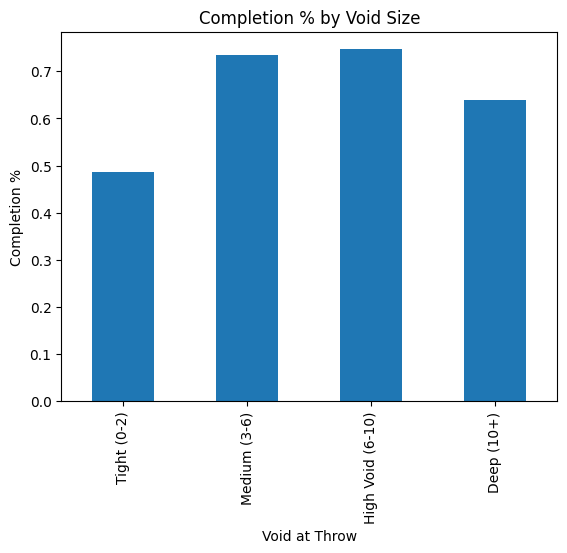

In [4]:
import matplotlib.pyplot as plt

# Binned version for viz
df['s_throw_band'] = pd.cut(df['p_dist_at_throw'], 
                            bins=[0, 2, 6, 10, float('inf')],
                            labels=['Tight (0-2)', 'Medium (3-6)', 'High Void (6-10)', 'Deep (10+)'])

completion_by_band = df.groupby('s_throw_band')['completion_binary'].agg(['mean', 'count'])
print(completion_by_band)

# Plot
completion_by_band['mean'].plot(kind='bar', title='Completion % by Void Size')
plt.ylabel('Completion %')
plt.xlabel('Void at Throw')
plt.show()


In [6]:
import pandas as pd

# 1. Load your processed data
df_summary = pd.read_csv('../data/processed/eraser_analysis_summary.csv')
df_supp = pd.read_csv('../data/supplementary_data.csv')

# --- DEBUG 1: CHECK THE ID FORMAT ---
# The leaderboard showed "53494.0" (Float). If we query 53494 (Int), it might fail.
cisco_id_float = 53494.0
cisco_id_int = 53494

print(f"Total rows in summary: {len(df_summary)}")

# Try finding him with loose filtering
cisco_rows = df_summary[df_summary['nfl_id'].isin([cisco_id_float, cisco_id_int])]
print(f"Rows found for Andre Cisco: {len(cisco_rows)}")

if len(cisco_rows) == 0:
    print("CRITICAL: Player ID not found. Listing unique IDs to check format...")
    print(df_summary['nfl_id'].unique()[:5]) # Show first 5 IDs
else:
    # --- DEBUG 2: CHECK THE VALUES ---
    # If we found him, let's look at his max scores
    print("\n--- STATS FOR CISCO ---")
    print(cisco_rows[['dist_at_throw', 'vis_score', 'ceoe_score']].describe())
    
    # --- DEBUG 3: FIND THE BEST PLAY MANUALLY ---
    # Sort by VIS to see his best play, regardless of your >8 filter
    best_play = cisco_rows.sort_values('vis_score', ascending=False).iloc[0]
    
    print("\n--- HIS #1 PLAY (No Filters) ---")
    print(f"GameID: {best_play['game_id']}")
    print(f"PlayID: {best_play['play_id']}")
    print(f"Start Dist: {best_play['dist_at_throw']}")
    print(f"VIS Score:  {best_play['vis_score']}")

Total rows in summary: 5191
Rows found for Andre Cisco: 21

--- STATS FOR CISCO ---
       dist_at_throw  vis_score  ceoe_score
count      21.000000  21.000000   21.000000
mean        4.340849   4.954265    2.749902
std         2.590964   4.054852    3.516087
min         0.450000  -1.096584   -2.806836
25%         2.024105   1.383548   -0.241924
50%         3.880322   5.218393    3.784587
75%         5.459524   8.473618    5.375730
max        10.279066  12.540478    7.635933

--- HIS #1 PLAY (No Filters) ---
GameID: 2024010702
PlayID: 1260
Start Dist: 4.542092029010424
VIS Score:  12.540477585929551


/tmp/ipykernel_149568/2967547029.py:5: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df_supp = pd.read_csv('../data/supplementary_data.csv')
